# UCI regression eval

In [4]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [72]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18

cmap = {
    "E-ANN-1": "crimson",
    "WLF-IMQ": "dodgerblue",
    "EKF": "lightseagreen",
    "WLF-MD": "gold", # TODO: make more o-paco
    "OGD": "blueviolet"
}

In [6]:
path_base = "./results"
# experiment_names = [f for f in os.listdir(path_base) if ("-target" in f) and ("p-error" not in f)]
experiment_names = [f for f in os.listdir(path_base) if ("-target" in f) and ("p-error10" in f)]
sorted(experiment_names)

['bostonHousing-target-p-error10.pkl',
 'concrete-target-p-error10.pkl',
 'energy-target-p-error10.pkl',
 'kin8nm-target-p-error10.pkl',
 'naval-propulsion-plant-target-p-error10.pkl',
 'power-plant-target-p-error10.pkl',
 'protein-tertiary-structure-target-p-error10.pkl',
 'wine-quality-red-target-p-error10.pkl',
 'yacht-target-p-error10.pkl']

In [7]:
df_results_all = []
for file_name in experiment_names:
    dataset = file_name.replace("-target.pkl", "")
    path = os.path.join(path_base, file_name)
    with open(path, "rb") as f:
        experiment = pickle.load(f)

    errors = experiment["methods"]

    df_results = pd.DataFrame({
        name: errors[name].median(axis=0)
        for name in errors
    })

    df_results = df_results.melt()
    df_results["dataset"] = dataset
    df_results_all.append(df_results)

df_results_all = pd.concat(df_results_all, axis=0)

# Root median squared error
df_results_all["value"] = np.sqrt(df_results_all["value"])
df_results_all["dataset"] = df_results_all["dataset"].str.replace("-.*", "", regex=True).str.capitalize()

In [8]:
def format_entry(entry):
    entry = entry[entry < 1000]
    mean = entry.mean()
    std = entry.std()
    if std > 1000:
        label = rf"$-$"
    else:
        label = rf"${mean:0.3f} \pm {std:0.3f}$"
    return label

In [9]:
res = (
    df_results_all
    .pivot_table(columns="variable", index="dataset", values="value", aggfunc=format_entry)
)
res

variable,E-ANN-1,EKF,OGD,WLF-IMQ,WLF-MD
dataset,,,,,
Bostonhousing,$0.063 \pm 0.007$,$1.557 \pm 0.533$,$0.799 \pm 0.417$,$0.077 \pm 0.008$,$0.071 \pm 0.006$
Concrete,$1.330 \pm 6.964$,$1.150 \pm 0.358$,$0.501 \pm 0.147$,$0.097 \pm 0.009$,$0.093 \pm 0.008$
Energy,$0.045 \pm 0.004$,$2.642 \pm 0.703$,$0.572 \pm 0.212$,$0.051 \pm 0.004$,$0.044 \pm 0.003$
Kin8nm,$0.099 \pm 0.020$,$0.784 \pm 0.187$,$0.431 \pm 0.092$,$0.097 \pm 0.004$,$0.091 \pm 0.004$
Naval,$1.198 \pm 7.010$,$0.947 \pm 0.211$,$0.376 \pm 0.056$,$0.178 \pm 0.006$,$0.120 \pm 0.005$
Power,$0.059 \pm 0.017$,$0.594 \pm 0.119$,$0.381 \pm 0.072$,$0.051 \pm 0.001$,$0.049 \pm 0.001$
Protein,$0.217 \pm 0.013$,$0.488 \pm 0.076$,$0.330 \pm 0.030$,$0.203 \pm 0.002$,$0.192 \pm 0.002$
Wine,$11.544 \pm 76.533$,$0.967 \pm 0.330$,$0.871 \pm 0.327$,$0.109 \pm 0.014$,$0.107 \pm 0.014$
Yacht,$0.113 \pm 0.017$,$1.599 \pm 0.592$,$1.216 \pm 0.454$,$0.126 \pm 0.023$,$0.124 \pm 0.022$


In [10]:
print(res.style.to_latex(hrules=True).replace("_", "-"))

\begin{tabular}{llllll}
\toprule
variable & E-ANN-1 & EKF & OGD & WLF-IMQ & WLF-MD \\
dataset &  &  &  &  &  \\
\midrule
Bostonhousing & $0.063 \pm 0.007$ & $1.557 \pm 0.533$ & $0.799 \pm 0.417$ & $0.077 \pm 0.008$ & $0.071 \pm 0.006$ \\
Concrete & $1.330 \pm 6.964$ & $1.150 \pm 0.358$ & $0.501 \pm 0.147$ & $0.097 \pm 0.009$ & $0.093 \pm 0.008$ \\
Energy & $0.045 \pm 0.004$ & $2.642 \pm 0.703$ & $0.572 \pm 0.212$ & $0.051 \pm 0.004$ & $0.044 \pm 0.003$ \\
Kin8nm & $0.099 \pm 0.020$ & $0.784 \pm 0.187$ & $0.431 \pm 0.092$ & $0.097 \pm 0.004$ & $0.091 \pm 0.004$ \\
Naval & $1.198 \pm 7.010$ & $0.947 \pm 0.211$ & $0.376 \pm 0.056$ & $0.178 \pm 0.006$ & $0.120 \pm 0.005$ \\
Power & $0.059 \pm 0.017$ & $0.594 \pm 0.119$ & $0.381 \pm 0.072$ & $0.051 \pm 0.001$ & $0.049 \pm 0.001$ \\
Protein & $0.217 \pm 0.013$ & $0.488 \pm 0.076$ & $0.330 \pm 0.030$ & $0.203 \pm 0.002$ & $0.192 \pm 0.002$ \\
Wine & $11.544 \pm 76.533$ & $0.967 \pm 0.330$ & $0.871 \pm 0.327$ & $0.109 \pm 0.014$ & $0.107 \pm 0

In [34]:
(
    df_results_all
    .pivot_table(columns="variable", index="dataset", values="value", aggfunc=lambda x: (x > 1000).sum())
)

variable,E-ANN-1,EKF,OGD,WLF-IMQ,WLF-MD
dataset,,,,,
Bostonhousing,0,0,0,0,0
Concrete,5,0,0,0,0
Energy,0,0,0,0,0
Kin8nm,1,0,0,0,0
Naval,0,0,0,0,0
Power,1,0,0,0,0
Protein,0,0,0,0,0
Wine,8,0,0,0,0
Yacht,0,0,0,0,0


## Experiments

In [83]:
sorted(experiment_names)

['bostonHousing-target-p-error10.pkl',
 'concrete-target-p-error10.pkl',
 'energy-target-p-error10.pkl',
 'kin8nm-target-p-error10.pkl',
 'naval-propulsion-plant-target-p-error10.pkl',
 'power-plant-target-p-error10.pkl',
 'protein-tertiary-structure-target-p-error10.pkl',
 'wine-quality-red-target-p-error10.pkl',
 'yacht-target-p-error10.pkl']

In [94]:
targets = [
    "concrete-target-p-error10.pkl",
    "kin8nm-target-p-error10.pkl",
    "naval-propulsion-plant-target-p-error10.pkl",
    "yacht-target-p-error10.pkl",
]

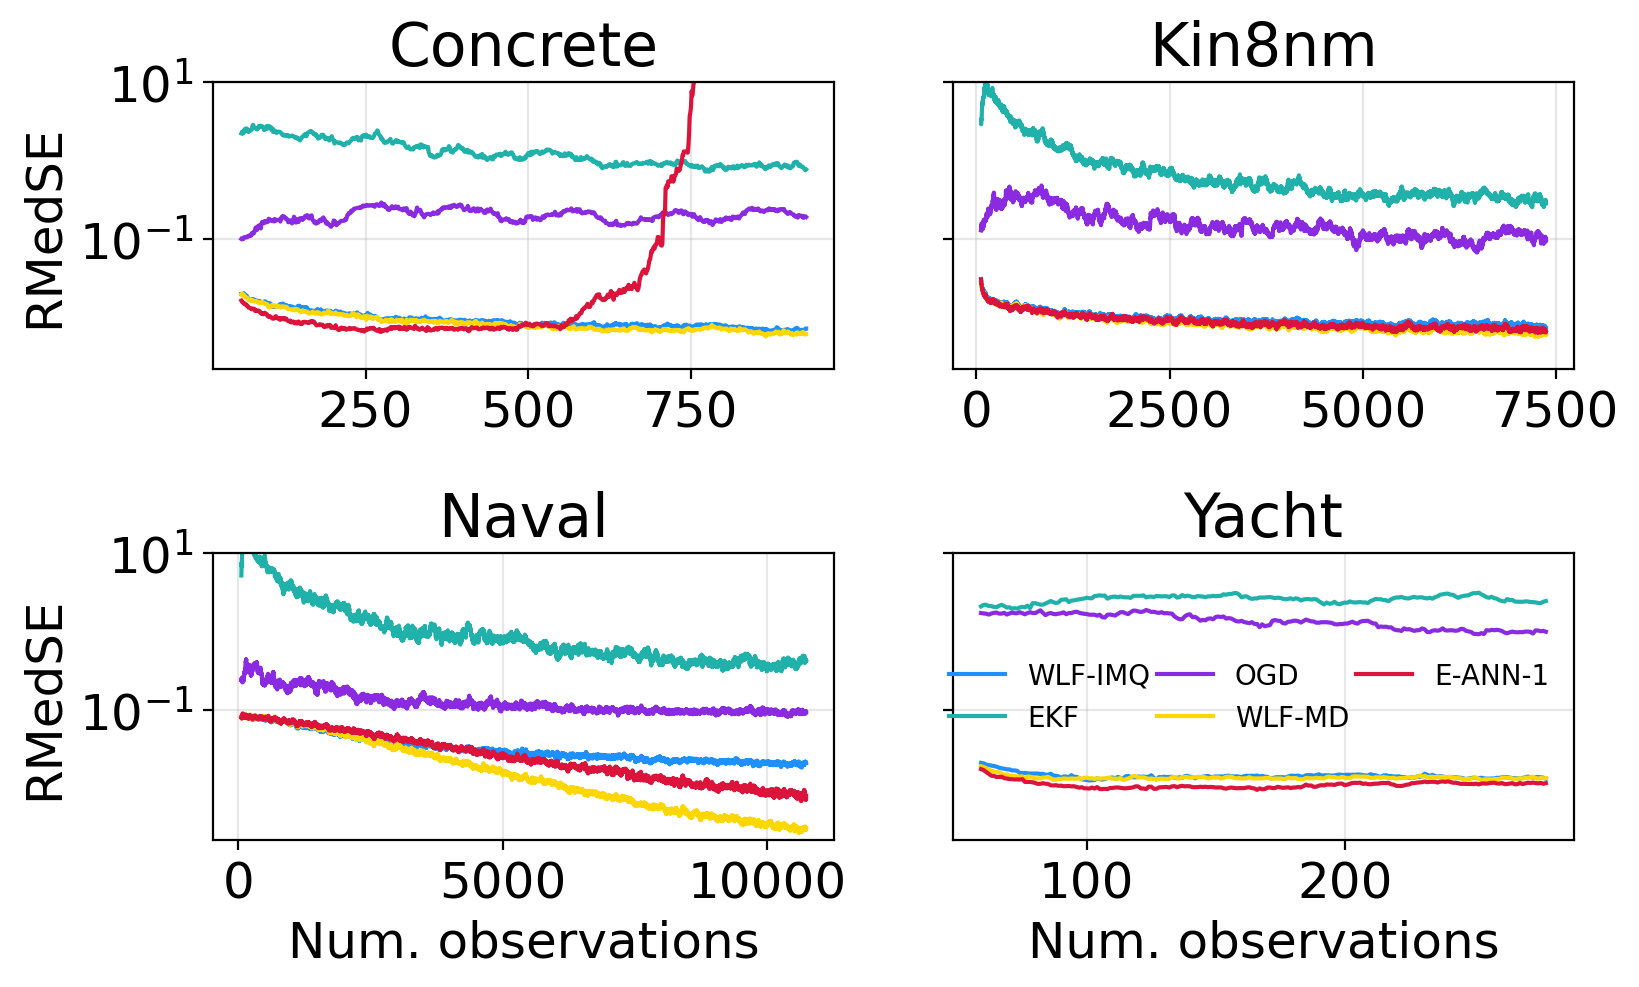

In [171]:
fig, axs = plt.subplots(2, 2, figsize=(6.4 * 1.3, 4.8 * 1.1), sharey=True)
for ax, file_name in zip(axs.ravel(), targets):
    dataset = file_name.replace("-target-p-error10.pkl", "")
    path = os.path.join(path_base, file_name)
    with open(path, "rb") as f:
        experiment = pickle.load(f)

    errors = experiment["methods"]

    for method in errors:
        errors[method][10:].rolling(50).median().median(axis=1).plot(label=method, c=cmap[method], ax=ax)
    ax.set_yscale("log")
    ax.grid(alpha=0.3)
    ax.set_title(re.sub("-.*", "", dataset).capitalize())
    ax.set_ylim(top=10 ** 1)
plt.subplots_adjust(
    hspace=0.6
)
axs[1, 1].legend(ncol=3, fontsize=10, columnspacing=0.25, fancybox=False, frameon=False, alignment="left")
axs[0, 0].set_ylabel("RMedSE")
axs[1, 0].set_ylabel("RMedSE")
axs[1, 0].set_xlabel("Num. observations")
axs[1, 1].set_xlabel("Num. observations")
plt.tight_layout()
plt.savefig("./figures/uci-dataset-training-error.pdf")